<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myProspects_Buy_Sell_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=d505ff4efe032c190b6841cf1e981be08daeea7d6dede339a212061088157e7d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

mypf = pd.read_csv('/content/drive/My Drive/data/stocks/myProspectsScrips.csv')

mypf = mypf[mypf['Criteria'] == 'V40']

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
#stock_ids

Mounted at /content/drive


In [3]:
# import necessary libraries 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib 
yfin.pdr_override()
import pandas_ta as ta

In [4]:
# function to compute stock attributes

def stock_prec_dev(stock_symbol, date):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20 
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'    
    
    end_date = date.strftime('%Y-%m-%d')
    start_date = (date + datetime.timedelta(days=-365*3)).strftime('%Y-%m-%d')
    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    #start = datetime.datetime(*map(int, start_date.split('-')))
    #end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = yfin.Ticker(stock_symbol).history(period='3y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)     

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df['Close'] = round(stock_df['Close'],0) 
    stock_df.drop(['Open', 'Low', 'High', 'Volume'
                   ], axis=1, inplace=True)   
    
    return stock_df

def get_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))    
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0  
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal']) 

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal']) 

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()
    
    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]    
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)
    
    return df_pos.tail(1)

def get_daily_buy_sell():
    df_buy_sell = pd.DataFrame()
    for stock_id in stock_ids:
        df_tmp = get_stock_buy_sell(stock_id+'.NS')
        df_buy_sell = df_buy_sell.append(df_tmp)
        
    df_buy_sell['Position'] = df_buy_sell['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')    
    return df_buy_sell.sort_index()

def plot_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))    
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0  
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal']) 

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal']) 

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df_prec_dev['Close'].plot(color = 'k', lw = 1, label = 'Close')  
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    df_prec_dev['20_SMA'].plot(color = 'g', lw = 1, label = '20_SMA')
    df_prec_dev['50_SMA'].plot(color = 'm', lw = 1, label = '50_SMA')
    df_prec_dev['200_SMA'].plot(color = 'b', lw = 1, label = '200_SMA') 

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]    
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)


    # plot 'buy' signals
    plt.plot(df_pos[df_pos['Position'] >= 1].index, 
          df_pos['Close'][df_pos['Position'] >= 1], 
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df_pos[df_pos['Position'] <= -1].index, 
          df_pos['Close'][df_pos['Position'] <= -1], 
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')

    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(stock_symbol + '  : Buy/Sell Signal', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    display_table = True

    if display_table == True:
      print(stock_symbol)
      df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
      print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

df_daily_buy_sell = get_daily_buy_sell()

In [5]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Sell'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position
Date,,,,,,,,
2020-12-28 00:00:00+05:30,186.0,183.0,168.0,167.0,ITC.NS,11.41,-1.0,Sell
2022-07-15 00:00:00+05:30,2551.0,2349.0,2253.0,2246.0,HINDUNILVR.NS,13.60,-1.0,Sell
2022-07-20 00:00:00+05:30,19762.0,18855.0,18080.0,18058.0,ABBOTINDIA.NS,9.43,-1.0,Sell
2022-08-10 00:00:00+05:30,849.0,797.0,747.0,746.0,ICICIBANK.NS,13.77,-1.0,Sell
2022-08-18 00:00:00+05:30,19345.0,19100.0,18061.0,18009.0,NESTLEIND.NS,7.42,-1.0,Sell
2022-08-30 00:00:00+05:30,1919.0,1909.0,1858.0,1854.0,AKZOINDIA.NS,3.49,-1.0,Sell
2022-09-08 00:00:00+05:30,780.0,753.0,716.0,714.0,AXISBANK.NS,9.21,-1.0,Sell
2022-09-08 00:00:00+05:30,6272.0,5447.0,5071.0,5055.0,BAJAJHLDNG.NS,24.08,-1.0,Sell
2022-09-09 00:00:00+05:30,1482.0,1467.0,1412.0,1411.0,HDFCBANK.NS,5.00,-1.0,Sell


In [6]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Buy'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position
Date,,,,,,,,
2021-12-17 00:00:00+05:30,1348.0,1426.0,1472.0,1475.0,ICICIGI.NS,-8.63,1.0,Buy
2022-01-24 00:00:00+05:30,320.0,342.0,348.0,365.0,NAM-INDIA.NS,-12.39,1.0,Buy
2022-05-13 00:00:00+05:30,1435.0,1505.0,1513.0,1542.0,GLAXO.NS,-6.91,1.0,Buy
2022-11-11 00:00:00+05:30,1531.0,1564.0,1650.0,1653.0,WHIRLPOOL.NS,-7.41,1.0,Buy
2022-11-22 00:00:00+05:30,1680.0,1771.0,1810.0,1811.0,BATAINDIA.NS,-7.22,1.0,Buy
2022-11-22 00:00:00+05:30,467.0,495.0,520.0,522.0,ICICIPRULI.NS,-10.47,1.0,Buy
2023-01-05 00:00:00+05:30,2984.0,3073.0,3088.0,3090.0,ASIANPAINT.NS,-3.42,1.0,Buy
2023-01-06 00:00:00+05:30,4961.0,4977.0,5040.0,5049.0,GILLETTE.NS,-1.74,1.0,Buy
2023-01-09 00:00:00+05:30,41270.0,43165.0,45715.0,45729.0,PAGEIND.NS,-9.75,1.0,Buy


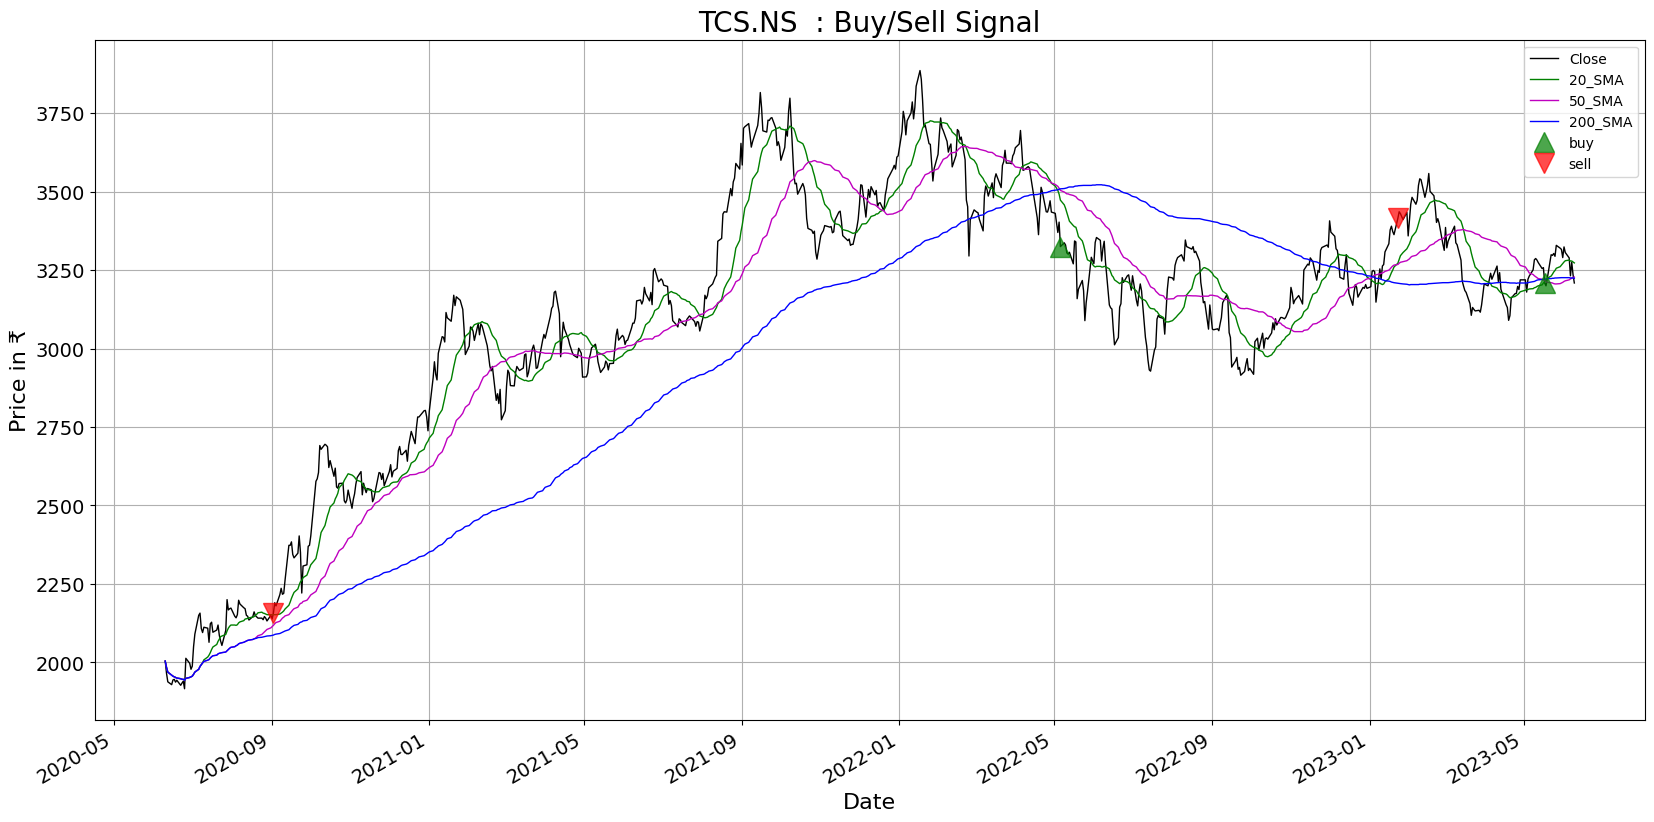

TCS.NS
+---------------------------+---------+----------+----------+-----------+---------+------------+----------+------------+
| Date                      |   Close |   20_SMA |   50_SMA |   200_SMA | Stock   |   Dev%_200 |   Signal | Position   |
|---------------------------+---------+----------+----------+-----------+---------+------------+----------+------------|
| 2020-09-02 00:00:00+05:30 |    2157 |     2152 |     2118 |      2087 | TCS.NS  |       3.36 |       -1 | Sell       |
| 2022-05-06 00:00:00+05:30 |    3325 |     3473 |     3504 |      3509 | TCS.NS  |      -5.26 |        1 | Buy        |
| 2023-01-23 00:00:00+05:30 |    3415 |     3272 |     3268 |      3208 | TCS.NS  |       6.45 |       -1 | Sell       |
| 2023-05-17 00:00:00+05:30 |    3209 |     3213 |     3217 |      3221 | TCS.NS  |      -0.38 |        1 | Buy        |
+---------------------------+---------+----------+----------+-----------+---------+------------+----------+------------+


In [7]:
stock_symbol = 'TCS.NS'
plot_stock_buy_sell(stock_symbol)